In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
from scipy.io import loadmat

In [61]:
# Directory containing the .png and .mat files
data_dir = '/Users/masonjp2/Library/CloudStorage/Box-Box/SunCET/7000 Testing/7105 CSIE/CSIE Images/2024-05-20 Darks over temp/'

In [62]:
# Fixed parameters
gain = 1.8 # [DN/e-]
integration_time = 0.150 # [seconds] PARAM_CAP_FRM_INTG_PRD
dn_bias = 5700 # [DN]

Sorted Image Statistics (in e-/s):
 [[ -57.58240371  -48.14814815  324.46875969 1062.96296296]
 [  -3.71830797    3.7037037   319.20662467 1100.        ]
 [  10.98170681   18.51851852  318.95225432 1085.18518519]
 [  24.52839219   33.33333333  316.55565592 1088.88888889]
 [  35.89769873   44.44444444  315.27376385 1092.59259259]
 [  54.10991923   62.96296296  313.48084853 1159.25925926]
 [  89.47605275  100.          309.16193946 1118.51851852]
 [ 107.35046666  114.81481481  305.44826817 1148.14814815]
 [ 124.10305851  133.33333333  305.22847004 1177.77777778]
 [ 134.51385318  144.44444444  303.16393347 1137.03703704]
 [ 138.43872513  148.14814815  303.36156339 1200.        ]
 [ 151.1224377   159.25925926  303.57114963 1170.37037037]
 [ 155.63126108  162.96296296  303.19217594 1122.22222222]
 [ 216.53628103  225.92592593  301.293652   1222.22222222]
 [ 250.89145365  259.25925926  303.53331513 1211.11111111]
 [ 278.55582398  288.88888889  306.26615891 1300.        ]
 [ 298.07191933  311

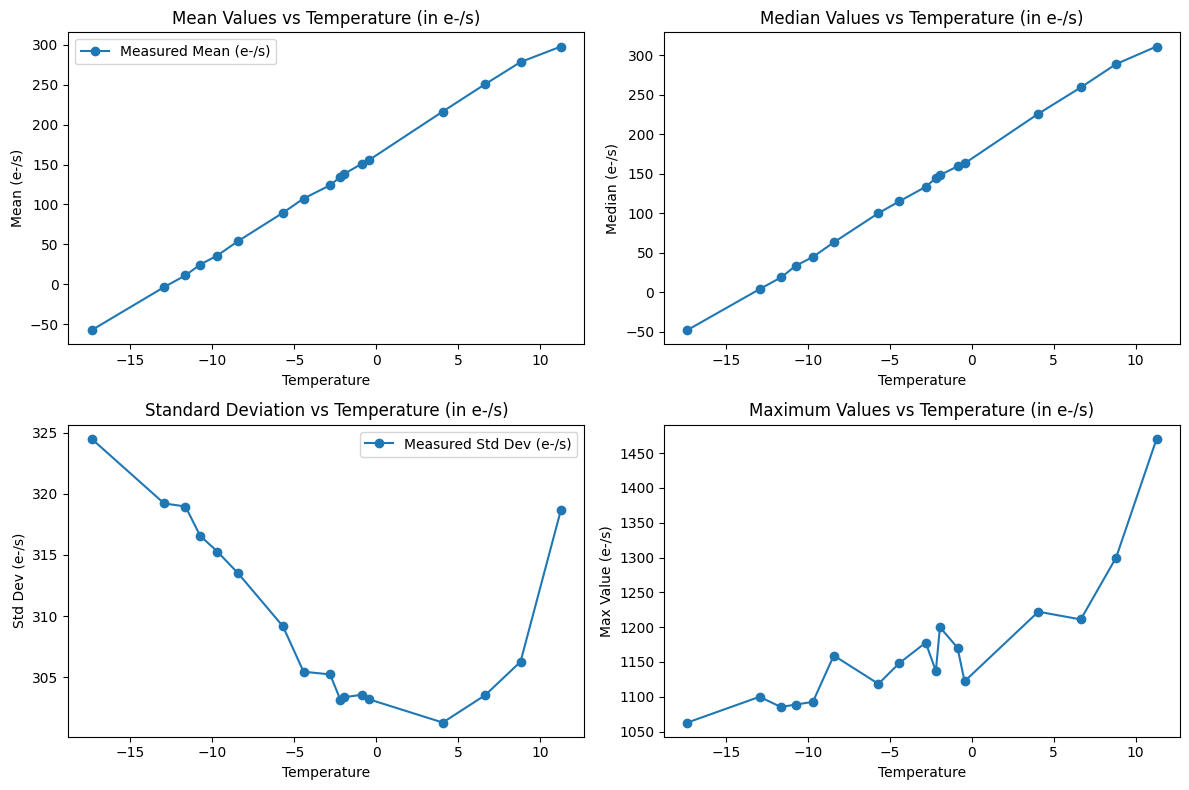

In [63]:
# Initialize lists to store the statistics and temperatures
image_stats = []
temperatures = []

# Loop over all .png files in the directory
for image_path in glob.glob(os.path.join(data_dir, '*.png')):
    # Extract the base filename (without extension) to match with .mat file
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    mat_filename = f"{base_filename}.mat"
    mat_path = os.path.join(data_dir, mat_filename)
    
    # Open the image file
    with Image.open(image_path) as img:
        # Convert the image to a numpy array
        img_array = np.array(img)
        
        # Subtract the bias from the DN values
        img_array = img_array - dn_bias
        
        # Calculate basic statistics in DN
        mean_val_dn = np.mean(img_array)
        median_val_dn = np.median(img_array)
        std_val_dn = np.std(img_array)
        max_val_dn = np.max(img_array)
        
        # Convert DN to e- using the gain factor
        mean_val_e = mean_val_dn / gain
        median_val_e = median_val_dn / gain
        std_val_e = std_val_dn / gain
        max_val_e = max_val_dn / gain
        
        # Convert e- to e-/s using the integration time
        mean_val_e_per_s = mean_val_e / integration_time
        median_val_e_per_s = median_val_e / integration_time
        std_val_e_per_s = std_val_e / integration_time
        max_val_e_per_s = max_val_e / integration_time
        
        # Append the statistics in e-/s to the list
        image_stats.append([mean_val_e_per_s, median_val_e_per_s, std_val_e_per_s, max_val_e_per_s])
    
    # Read the corresponding .mat file for temperature data
    if os.path.exists(mat_path):
        mat_data = loadmat(mat_path)
        temperature = mat_data['HKD_THRM_DET0'][0][0]  # Adjust indexing if necessary
        temperatures.append(temperature)
    else:
        print(f"Warning: No corresponding .mat file found for {image_path}")

# Convert lists to numpy arrays for easier manipulation
image_stats = np.array(image_stats)
temperatures = np.array(temperatures)

# Sort the data by temperature
sorted_indices = np.argsort(temperatures)
sorted_temperatures = temperatures[sorted_indices]
sorted_image_stats = image_stats[sorted_indices]

# Calculate theoretical values for dark current mean and std
theoretical_mean = 20 * 2**((sorted_temperatures - 20) / 5.5)
theoretical_std = 12 * 2**((sorted_temperatures - 20) / 5.5)

# Print the sorted array of statistics and temperatures
print("Sorted Image Statistics (in e-/s):\n", sorted_image_stats)
print("Sorted Temperatures:\n", sorted_temperatures)
print("Theoretical Mean:\n", theoretical_mean)
print("Theoretical Std Dev:\n", theoretical_std)

# Optional: Save the statistics and temperatures to a file for later use
np.savetxt('sorted_image_statistics_with_temperatures_e_per_s.csv', np.column_stack((sorted_image_stats, sorted_temperatures)), 
           delimiter=',', header='Mean,Median,Std,Max,Temperature', comments='')

# Plotting the statistics against temperature with theoretical values
plt.figure(figsize=(12, 8))

# Plot mean values against temperature
plt.subplot(2, 2, 1)
plt.plot(sorted_temperatures, sorted_image_stats[:, 0], 'o-', label='Measured Mean (e-/s)')
#plt.plot(sorted_temperatures, theoretical_mean, 'r--', label='Theoretical Mean (e-/s)')
plt.title('Mean Values vs Temperature (in e-/s)')
plt.xlabel('Temperature')
plt.ylabel('Mean (e-/s)')
plt.legend()

# Plot median values against temperature
plt.subplot(2, 2, 2)
plt.plot(sorted_temperatures, sorted_image_stats[:, 1], 'o-')
plt.title('Median Values vs Temperature (in e-/s)')
plt.xlabel('Temperature')
plt.ylabel('Median (e-/s)')

# Plot standard deviation values against temperature
plt.subplot(2, 2, 3)
plt.plot(sorted_temperatures, sorted_image_stats[:, 2], 'o-', label='Measured Std Dev (e-/s)')
#plt.plot(sorted_temperatures, theoretical_std, 'r--', label='Theoretical Std Dev (e-/s)')
plt.title('Standard Deviation vs Temperature (in e-/s)')
plt.xlabel('Temperature')
plt.ylabel('Std Dev (e-/s)')
plt.legend()

# Plot maximum values against temperature
plt.subplot(2, 2, 4)
plt.plot(sorted_temperatures, sorted_image_stats[:, 3], 'o-')
plt.title('Maximum Values vs Temperature (in e-/s)')
plt.xlabel('Temperature')
plt.ylabel('Max Value (e-/s)')

plt.tight_layout()
plt.show()


In [126]:
detector_temperature = -7
dark_current_mean = 20 * 2**((detector_temperature - 20) / 5.5)
dark_current_std = 12 * 2**((detector_temperature - 20) / 5.5)
print('expected dark current is {} ± {} at temperature of {}'.format(dark_current_mean, dark_current_std, detector_temperature))

expected dark current is 0.6656506808999767 ± 0.399390408539986 at temperature of -7


Statistics for the difference image:
Mean: -21652.831075305377 e-/s
Median: -21668.074074074073 e-/s
Standard Deviation: 313.30965955349933 e-/s
Maximum Value: -20274.592592592595 e-/s


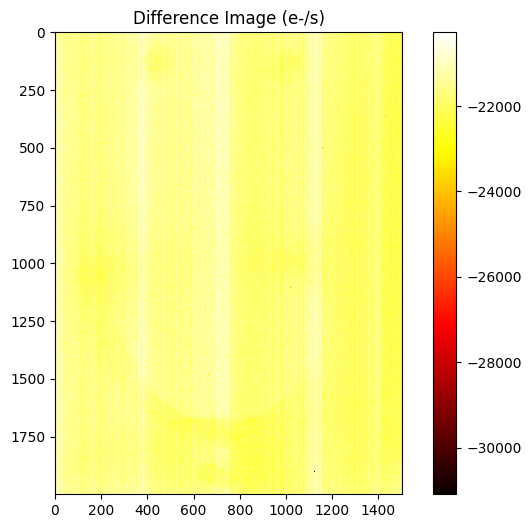

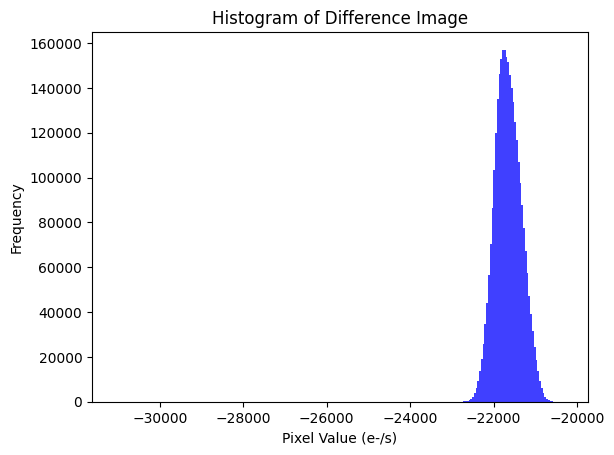

In [96]:
# Gain factor for conversion from DN to e-
gain = 1.8  # DN/e-

# Exposure times in seconds for the two images
integration_time_18_short = 0.150  # seconds
integration_time_18_long = 15 # seconds

# Bias in DN
dn_bias = 10000  # DN

# Filenames for the two images and their corresponding .mat files
filenames = ['18_short.png', '18_long.png']
mat_filenames = ['18_short.mat', '18_long.mat']

# Initialize lists to store the images and temperatures
images = []
temperatures = []

for filename, mat_filename in zip(filenames, mat_filenames):
    # Read the image file
    image_path = os.path.join(data_dir, filename)
    with Image.open(image_path) as img:
        img_array = np.array(img)
        images.append(img_array)
    
    # Read the corresponding .mat file for temperature data
    mat_path = os.path.join(data_dir, mat_filename)
    if os.path.exists(mat_path):
        mat_data = loadmat(mat_path)
        temperature = mat_data['HKD_THRM_DET0'][0][0]  # Adjust indexing if necessary
        temperatures.append(temperature)
    else:
        print(f"Warning: No corresponding .mat file found for {image_path}")

# Subtract the bias from both images
#images = [img - dn_bias for img in images]

# Convert to e-/s by dividing by gain and the respective integration times
img_18_e_per_s = (images[0] / gain) / integration_time_18_short
img_18_long_e_per_s = (images[1] / gain) / integration_time_18_long

# Subtract the two images
diff_img = img_18_long_e_per_s - img_18_e_per_s

# Calculate basic statistics on the resulting image
mean_val = np.mean(diff_img)
median_val = np.median(diff_img)
std_val = np.std(diff_img)
max_val = np.max(diff_img)

# Print the statistics
print("Statistics for the difference image:")
print(f"Mean: {mean_val} e-/s")
print(f"Median: {median_val} e-/s")
print(f"Standard Deviation: {std_val} e-/s")
print(f"Maximum Value: {max_val} e-/s")

# Plot the resulting image
plt.figure(figsize=(8, 6))
plt.imshow(diff_img, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Difference Image (e-/s)')
plt.show()

# Plot histogram of the resulting image
plt.figure()
plt.hist(diff_img.flatten(), bins=256, range=(np.min(diff_img), np.max(diff_img)), alpha=0.75, color='b')
plt.title('Histogram of Difference Image')
plt.xlabel('Pixel Value (e-/s)')
plt.ylabel('Frequency')
plt.show()


In [94]:
np.mean(img_18_long_e_per_s)

NameError: name 'img_18_long_e_per_s' is not defined

In [70]:
np.mean(img_17_e_per_s)

21053.52870739755

In [71]:
images

[array([[5624, 5564, 5606, ..., 5651, 5686, 5694],
        [5695, 5662, 5660, ..., 5699, 5727, 5754],
        [5655, 5628, 5645, ..., 5755, 5742, 5752],
        ...,
        [5626, 5563, 5587, ..., 5658, 5710, 5670],
        [5633, 5548, 5602, ..., 5663, 5686, 5723],
        [5646, 5562, 5593, ..., 5651, 5684, 5684]], dtype=int32),
 array([[5674, 5628, 5640, ..., 5678, 5726, 5726],
        [5723, 5687, 5691, ..., 5729, 5764, 5788],
        [5690, 5659, 5681, ..., 5762, 5748, 5784],
        ...,
        [5655, 5577, 5609, ..., 5695, 5707, 5677],
        [5658, 5548, 5598, ..., 5679, 5710, 5723],
        [5628, 5573, 5584, ..., 5671, 5683, 5733]], dtype=int32)]

In [75]:
np.max(images[0])

5987

In [74]:
np.max(images[1])

6000

In [77]:
np.min(diff_img)

-19970.74074074074

In [78]:
bla = img_17_long_e_per_s - img_17_e_per_s

In [79]:
bla

array([[-18728.14814815, -18522.96296296, -18674.07407407, ...,
        -18826.66666667, -18938.51851852, -18968.14814815],
       [-18972.96296296, -18864.07407407, -18855.18518519, ...,
        -18985.55555556, -19076.2962963 , -19167.40740741],
       [-18837.03703704, -18748.51851852, -18803.33333333, ...,
        -19180.74074074, -19137.77777778, -19161.48148148],
       ...,
       [-18742.59259259, -18538.14814815, -18615.18518519, ...,
        -18846.2962963 , -19034.44444444, -18897.40740741],
       [-18767.40740741, -18493.33333333, -18674.81481481, ...,
        -18870.74074074, -18944.44444444, -19076.66666667],
       [-18826.66666667, -18535.92592593, -18646.66666667, ...,
        -18829.25925926, -18947.03703704, -18928.51851852]])

In [101]:
image_path_short = os.path.join(data_dir, '18_short.png')
image_path_long = os.path.join(data_dir, '18_long.png')
with Image.open(image_path_short) as img:
        image_short = np.array(img)
with Image.open(image_path_long) as img:
        image_long = np.array(img)


In [98]:
np.mean(image_short)

5678.066019946808

In [99]:
np.mean(image_long)

5903.045050531915

In [102]:
diff_image = image_long - image_short

In [104]:
np.mean(diff_image)

224.9790305851064

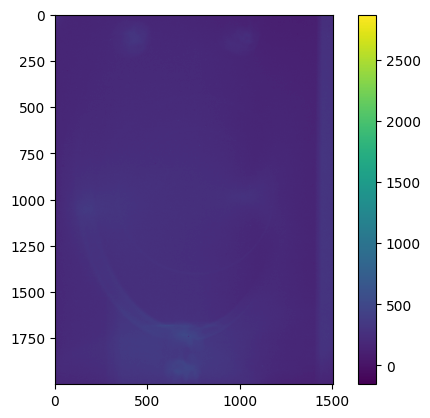

In [107]:
plt.imshow(diff_image)
plt.colorbar()

Text(0, 0.5, 'Frequency')

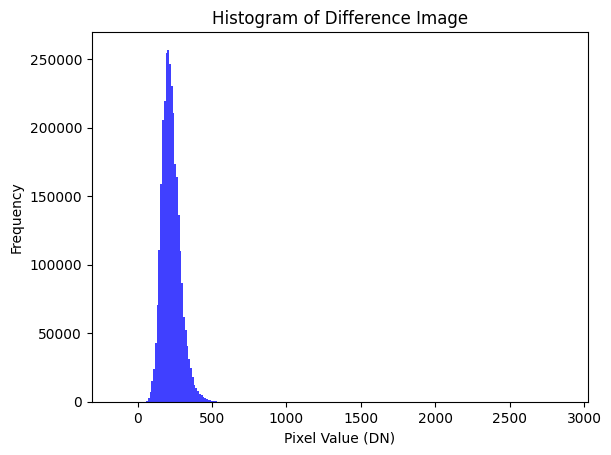

In [111]:
plt.hist(diff_image.flatten(), bins=256, range=(np.min(diff_image), np.max(diff_image)), alpha=0.75, color='b')
plt.title('Histogram of Difference Image')
plt.xlabel('Pixel Value (DN)')
plt.ylabel('Frequency')

In [110]:
np.mean(diff_image)

224.9790305851064

In [112]:
delta_t = integration_time_18_long - integration_time_18_short
diff_image_e_per_sec = diff_image / gain / (delta_t)

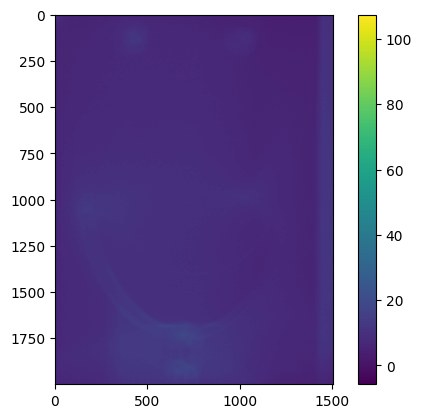

In [114]:
plt.imshow(diff_image_e_per_sec)
plt.colorbar()

Text(0, 0.5, 'Frequency')

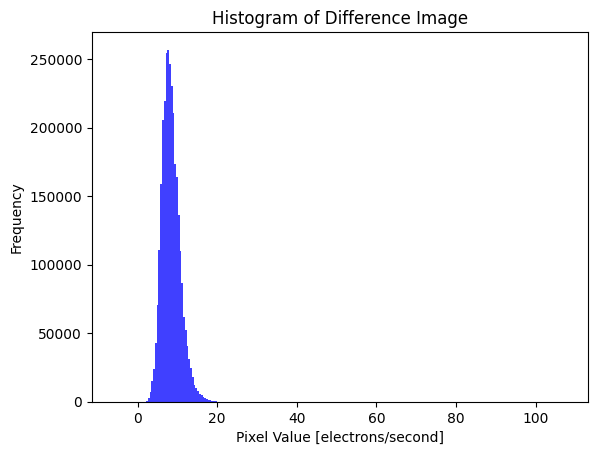

In [115]:
plt.hist(diff_image_e_per_sec.flatten(), bins=256, range=(np.min(diff_image_e_per_sec), np.max(diff_image_e_per_sec)), alpha=0.75, color='b')
plt.title('Histogram of Difference Image')
plt.xlabel('Pixel Value [electrons/second]')
plt.ylabel('Frequency')

In [116]:
np.mean(diff_image_e_per_sec)

8.416723927613411

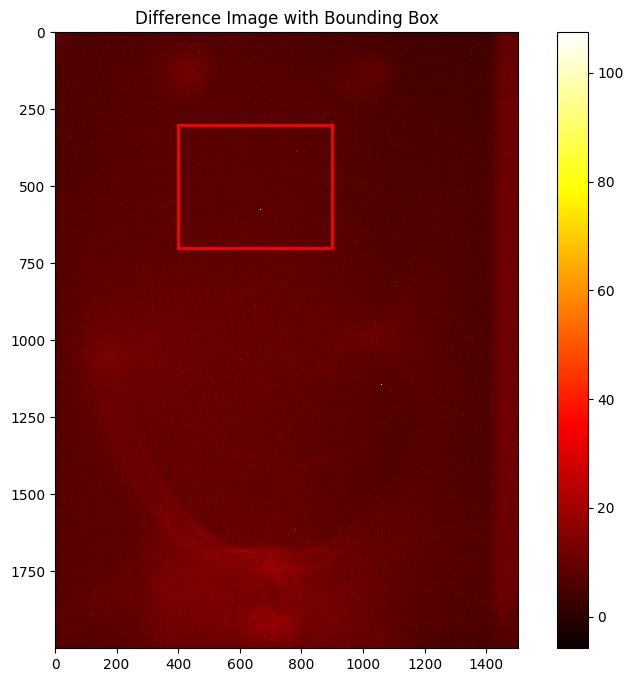

Statistics for the region of interest:
Mean: 7.966272914328469 e-/s
Median: 7.931163486719042 e-/s
Standard Deviation: 1.038475120535518 e-/s
Maximum Value: 76.2813318368874 e-/s


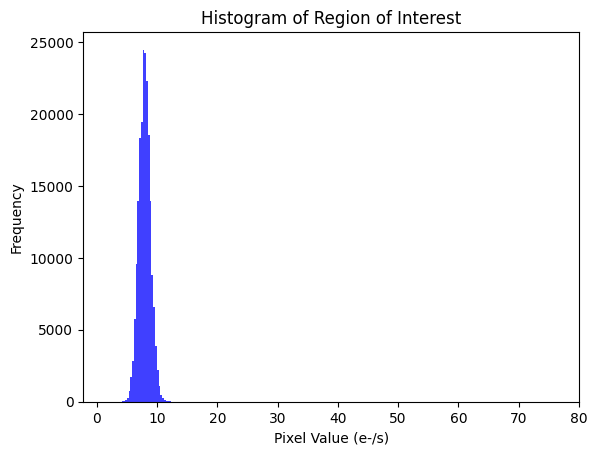

In [119]:
from matplotlib.patches import Rectangle

# Coordinates of the bounding box (x, y, width, height)
bbox = (400, 300, 500, 400)  # Adjust these values as needed

# Plot the image with the bounding box
plt.figure(figsize=(10, 8))
plt.imshow(diff_image_e_per_sec, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Difference Image with Bounding Box')

# Create a rectangle patch
rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

plt.show()

# Extract the region inside the bounding box
x, y, w, h = bbox
region_of_interest = diff_image_e_per_sec[y:y+h, x:x+w]

# Calculate basic statistics on the region of interest
mean_val = np.mean(region_of_interest)
median_val = np.median(region_of_interest)
std_val = np.std(region_of_interest)
max_val = np.max(region_of_interest)

# Print the statistics
print("Statistics for the region of interest:")
print(f"Mean: {mean_val} e-/s")
print(f"Median: {median_val} e-/s")
print(f"Standard Deviation: {std_val} e-/s")
print(f"Maximum Value: {max_val} e-/s")

# Plot histogram of the region of interest
plt.figure()
plt.hist(region_of_interest.flatten(), bins=256, range=(np.min(region_of_interest), np.max(region_of_interest)), alpha=0.75, color='b')
plt.title('Histogram of Region of Interest')
plt.xlabel('Pixel Value (e-/s)')
plt.ylabel('Frequency')
plt.show()


# PTC -- Pixel Transfer Function

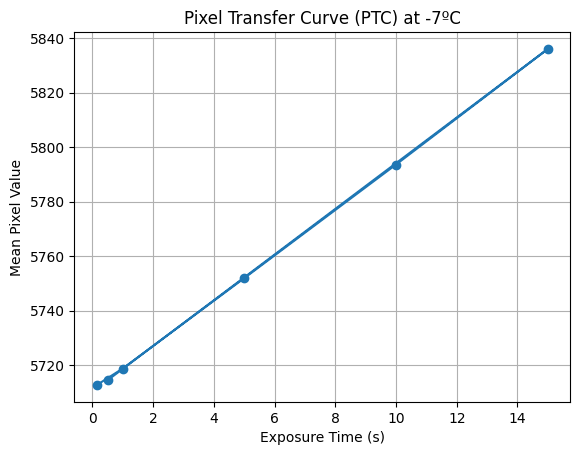

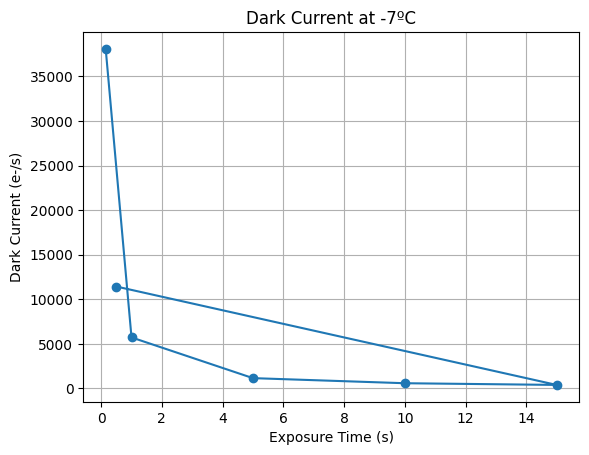

In [121]:
import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing the images
image_dir = "/Users/masonjp2/Library/CloudStorage/Box-Box/SunCET/7000 Testing/7105 CSIE/CSIE Images/2024-05-21 Darks over temp 2/Neg7/"

# Regular expression to extract exposure time from the filename
filename_pattern = re.compile(r'.*_(\d+\.\d+)s\.png')

# Lists to store exposure times and mean pixel values
exposure_times = []
mean_pixel_values = []

# Read and process each image
for filepath in glob.glob(os.path.join(image_dir, '*.png')):
    # Extract exposure time from filename
    filename = os.path.basename(filepath)
    match = filename_pattern.match(filename)
    if match:
        exposure_time = float(match.group(1))
        exposure_times.append(exposure_time)

        # Read the image
        image = Image.open(filepath)
        image_array = np.array(image)

        # Calculate mean pixel value
        mean_pixel_value = np.mean(image_array)
        mean_pixel_values.append(mean_pixel_value)

# Convert lists to numpy arrays for easier processing
exposure_times = np.array(exposure_times)
mean_pixel_values = np.array(mean_pixel_values)

# Calculate dark current (mean pixel value / exposure time)
dark_current = mean_pixel_values / exposure_times

# Plot the PTC (mean pixel value vs exposure time)
plt.figure()
plt.plot(exposure_times, mean_pixel_values, 'o-')
plt.xlabel('Exposure Time (s)')
plt.ylabel('Mean Pixel Value')
plt.title('Pixel Transfer Curve (PTC) at -7ºC')
plt.grid(True)
plt.show()

# Plot the dark current (dark current vs exposure time)
plt.figure()
plt.plot(exposure_times, dark_current, 'o-')
plt.xlabel('Exposure Time (s)')
plt.ylabel('Dark Current (e-/s)')
plt.title('Dark Current at -7ºC')
plt.grid(True)
plt.show()


# Basic analysis

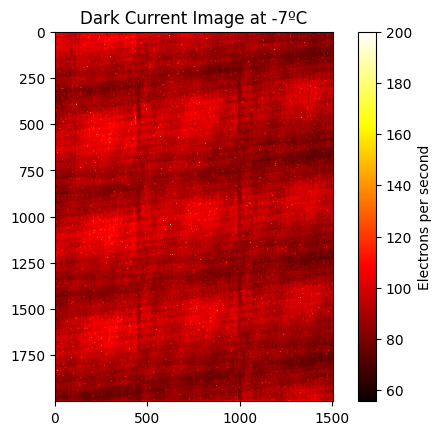

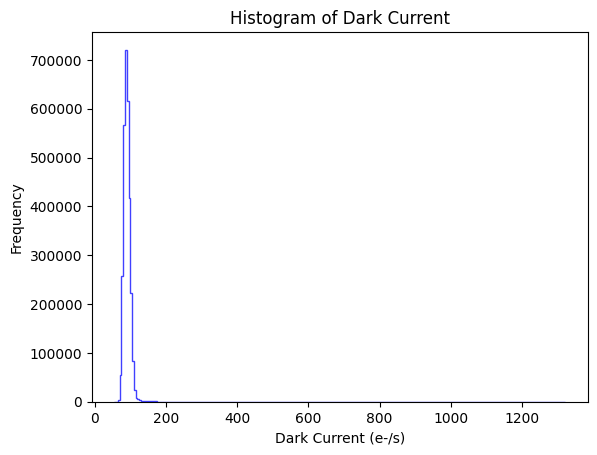

Statistics for the region of interest:
Mean: 91.03905582121455 e-/s
Median: 89.59970071081182 e-/s
Standard Deviation: 17.13413466924253 e-/s
Maximum Value: 1321.4365881032547 e-/s


In [139]:
import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing the images
image_dir = "/Users/masonjp2/Library/CloudStorage/Box-Box/SunCET/7000 Testing/7105 CSIE/CSIE Images/2024-05-21 Darks over temp 2/Pos23/"

# Regular expression to extract exposure time from the filename
filename_pattern = re.compile(r'.*_(\d+\.\d+)s\.png')

# Lists to store file paths and exposure times
filepaths = []
exposure_times = []

# Read each image file to get exposure times
for filepath in glob.glob(os.path.join(image_dir, '*.png')):
    filename = os.path.basename(filepath)
    match = filename_pattern.match(filename)
    if match:
        exposure_time = float(match.group(1))
        filepaths.append(filepath)
        exposure_times.append(exposure_time)

# Find the shortest and longest exposure times and their corresponding files
shortest_exposure_index = np.argmin(exposure_times)
longest_exposure_index = np.argmax(exposure_times)

shortest_exposure_time = exposure_times[shortest_exposure_index]
longest_exposure_time = exposure_times[longest_exposure_index]

shortest_filepath = filepaths[shortest_exposure_index]
longest_filepath = filepaths[longest_exposure_index]

# Load the shortest and longest exposure images
shortest_image = np.array(Image.open(shortest_filepath))
longest_image = np.array(Image.open(longest_filepath))

# Perform the calculation
gain = 1.8  # DN/electron
delta_integration_time = longest_exposure_time - shortest_exposure_time

result_image = (longest_image - shortest_image) / gain / delta_integration_time

# Display the resultant image
plt.figure()
plt.imshow(result_image, cmap='hot', vmax=200)
plt.colorbar(label='Electrons per second')
plt.title('Dark Current Image at -7ºC')
plt.show()

# Show a histogram of the data
plt.figure()
plt.hist(result_image.ravel(), bins=256, histtype='step', color='b', alpha=0.75)
plt.xlabel('Dark Current (e-/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Dark Current')
plt.show()


# Calculate basic statistics on the region of interest
mean_val = np.mean(result_image)
median_val = np.median(result_image)
std_val = np.std(result_image)
max_val = np.max(result_image)

# Print the statistics
print("Statistics for the region of interest:")
print(f"Mean: {mean_val} e-/s")
print(f"Median: {median_val} e-/s")
print(f"Standard Deviation: {std_val} e-/s")
print(f"Maximum Value: {max_val} e-/s")


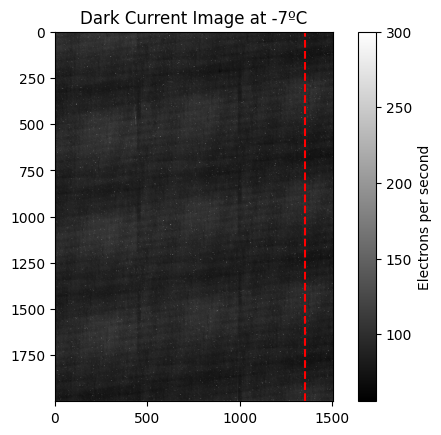

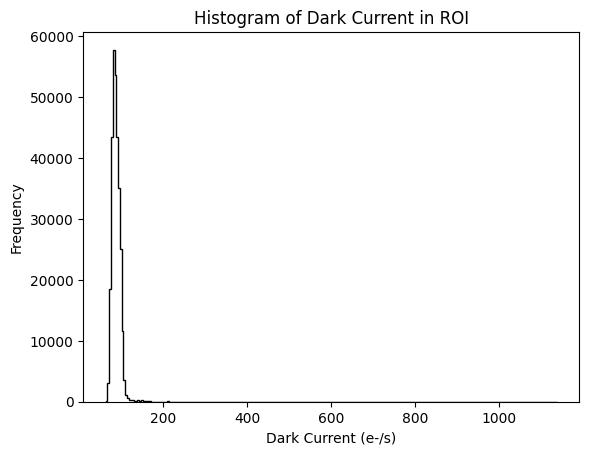

Mean dark current in ROI: 87.50 e-/s
Standard deviation of dark current in ROI: 16.67 e-/s


In [137]:
import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing the images
image_dir = "/Users/masonjp2/Library/CloudStorage/Box-Box/SunCET/7000 Testing/7105 CSIE/CSIE Images/2024-05-21 Darks over temp 2/Pos23/"

# Regular expression to extract exposure time from the filename
filename_pattern = re.compile(r'.*_(\d+\.\d+)s\.png')

# Lists to store file paths and exposure times
filepaths = []
exposure_times = []

# Read each image file to get exposure times
for filepath in glob.glob(os.path.join(image_dir, '*.png')):
    filename = os.path.basename(filepath)
    match = filename_pattern.match(filename)
    if match:
        exposure_time = float(match.group(1))
        filepaths.append(filepath)
        exposure_times.append(exposure_time)

# Find the shortest and longest exposure times and their corresponding files
shortest_exposure_index = np.argmin(exposure_times)
longest_exposure_index = np.argmax(exposure_times)

shortest_exposure_time = exposure_times[shortest_exposure_index]
longest_exposure_time = exposure_times[longest_exposure_index]

shortest_filepath = filepaths[shortest_exposure_index]
longest_filepath = filepaths[longest_exposure_index]

# Load the shortest and longest exposure images
shortest_image = np.array(Image.open(shortest_filepath))
longest_image = np.array(Image.open(longest_filepath))

# Perform the calculation
gain = 1.8  # DN/electron
delta_integration_time = longest_exposure_time - shortest_exposure_time

result_image = (longest_image - shortest_image) / gain / delta_integration_time

# Define the region of interest (rightmost 10% of the image)
height, width = result_image.shape
roi_width = width // 10
roi = result_image[:, -roi_width:]

# Compute statistics for the ROI
roi_mean = np.mean(roi)
roi_std = np.std(roi)

# Display the resultant image with ROI highlighted
plt.figure()
plt.imshow(result_image, cmap='gray', vmax=300)
plt.colorbar(label='Electrons per second')
plt.title('Dark Current Image at -7ºC')
# Highlight the ROI
plt.axvline(x=width - roi_width, color='red', linestyle='--')
plt.show()

# Show a histogram of the ROI data
plt.figure()
plt.hist(roi.ravel(), bins=256, histtype='step', color='black')
plt.xlabel('Dark Current (e-/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Dark Current in ROI')
plt.show()

# Print the statistics
print(f'Mean dark current in ROI: {roi_mean:.2f} e-/s')
print(f'Standard deviation of dark current in ROI: {roi_std:.2f} e-/s')


Mean dark current at -7ºC: 2.63 e-/s
Mean dark current at -6ºC: 2.97 e-/s
Mean dark current at -5ºC: 3.91 e-/s
Mean dark current at 0ºC: 4.64 e-/s
Mean dark current at 2ºC: 5.34 e-/s
Mean dark current at 4ºC: 6.47 e-/s
Mean dark current at 5ºC: 6.99 e-/s
Mean dark current at 10ºC: 13.82 e-/s
Mean dark current at 23ºC: 87.50 e-/s


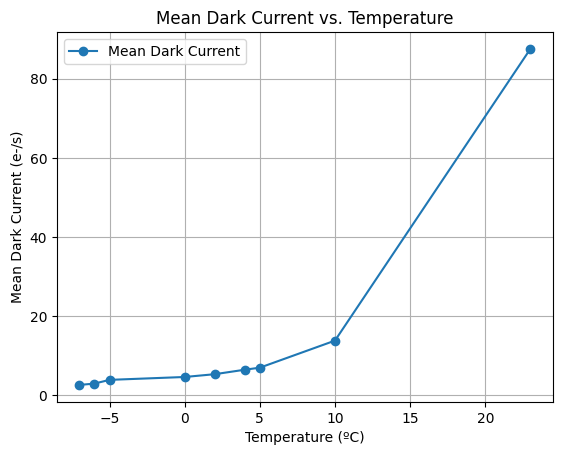

In [134]:
import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Parent directory containing the subfolders for different temperatures
parent_dir = "/Users/masonjp2/Library/CloudStorage/Box-Box/SunCET/7000 Testing/7105 CSIE/CSIE Images/2024-05-21 Darks over temp 2/"

# List of temperature subfolders
temperature_folders = ['Neg7', 'Neg6', 'Neg5', '0', 'Pos2', 'Pos4', 'Pos5', 'Pos10', 'Pos23']
temperatures = [-7, -6, -5, 0, 2, 4, 5, 10, 23]

# Regular expression to extract exposure time from the filename
filename_pattern = re.compile(r'.*_(\d+\.\d+)s\.png')

# Gain (DN/electron)
gain = 1.8

# Lists to store the temperature and corresponding mean dark current
mean_dark_current_per_temp = []

for temp_folder, temperature in zip(temperature_folders, temperatures):
    # Directory containing the images for the current temperature
    image_dir = os.path.join(parent_dir, temp_folder)
    
    # Lists to store file paths and exposure times
    filepaths = []
    exposure_times = []

    # Read each image file to get exposure times
    for filepath in glob.glob(os.path.join(image_dir, '*.png')):
        filename = os.path.basename(filepath)
        match = filename_pattern.match(filename)
        if match:
            exposure_time = float(match.group(1))
            filepaths.append(filepath)
            exposure_times.append(exposure_time)

    # Find the shortest and longest exposure times and their corresponding files
    shortest_exposure_index = np.argmin(exposure_times)
    longest_exposure_index = np.argmax(exposure_times)

    shortest_exposure_time = exposure_times[shortest_exposure_index]
    longest_exposure_time = exposure_times[longest_exposure_index]

    shortest_filepath = filepaths[shortest_exposure_index]
    longest_filepath = filepaths[longest_exposure_index]

    # Load the shortest and longest exposure images
    shortest_image = np.array(Image.open(shortest_filepath))
    longest_image = np.array(Image.open(longest_filepath))

    # Perform the calculation
    delta_integration_time = longest_exposure_time - shortest_exposure_time
    result_image = (longest_image - shortest_image) / gain / delta_integration_time

    # Define the region of interest (rightmost 10% of the image)
    height, width = result_image.shape
    roi_width = width // 10
    roi = result_image[:, -roi_width:]

    # Compute the mean dark current for the ROI
    roi_mean = np.mean(roi)
    mean_dark_current_per_temp.append(roi_mean)

    # Optionally, print the mean dark current for each temperature
    print(f'Mean dark current at {temperature}ºC: {roi_mean:.2f} e-/s')

# Plot the mean dark current versus temperature
plt.figure()
plt.plot(temperatures, mean_dark_current_per_temp, 'o-', label='Mean Dark Current')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Mean Dark Current (e-/s)')
plt.title('Mean Dark Current vs. Temperature')
plt.grid(True)
plt.legend()
plt.show()
